In [9]:
from operator import itemgetter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from sklearn.utils import shuffle
from sklearn.base import BaseEstimator, RegressorMixin

# display multiple outputs in same cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# restore objects and unpack them into variables
%store -r object_keep
df, df_adjust, test, model_features, model_target, X_train, X_test, y_train = itemgetter('df', 
                                                                                         'df_adjust',
                                                                                         'test',
                                                                                         'model_features',
                                                                                         'model_target',
                                                                                         'X_train', 
                                                                                         'X_test',
                                                                                         'y_train')(object_keep)

In [2]:
class PseudoLabeler(BaseEstimator, RegressorMixin):
    '''
    Sci-kit learn wrapper for creating pseudo-lebeled estimators.
    '''

    def __init__(self, model, unlabelled_data, features, target, sample_rate = 0.2, seed = 42):
        '''
        @sample_rate - percent of samples used as pseudo-labelled data
        from the unlabelled dataset
        '''
        assert sample_rate <= 1.0, 'Sample_rate should be between 0.0 and 1.0.'

        self.sample_rate = sample_rate
        self.seed = seed
        self.model = model
        self.model.seed = seed

        self.unlabelled_data = unlabelled_data
        self.features = features
        self.target = target

    def get_params(self, deep = True):
        return {
            "sample_rate": self.sample_rate,
            "seed": self.seed,
            "model": self.model,
            "unlabelled_data": self.unlabelled_data,
            "features": self.features,
            "target": self.target
        }

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def fit(self, X, y):
        '''
        Fit the data using pseudo labeling.
        '''

        augmented_train = self.__create_augmented_train(X, y)
        self.model.fit(
            augmented_train[self.features],
            augmented_train[self.target]
        )

        return self

    def __create_augmented_train(self, X, y):
        '''
        Create and return the augmented_train set that consists
        of pseudo-labeled and labeled data.
        '''
        num_of_samples = int(len(self.unlabelled_data) * self.sample_rate)

        # Train the model and create the pseudo-labels
        self.model.fit(X, y)
        pseudo_labels = self.model.predict(self.unlabelled_data[self.features])

        # Add the pseudo-labels to the test set
        pseudo_data = self.unlabelled_data.copy(deep = True)
        pseudo_data[self.target] = pseudo_labels

        # Take a subset of the test set with pseudo-labels and append in onto
        # the training set
        sampled_pseudo_data = pseudo_data.sample(n=num_of_samples)
        temp_train = pd.concat([X, y], axis=1)
        augemented_train = pd.concat([sampled_pseudo_data, temp_train])

        return shuffle(augemented_train)

    def predict(self, X):
        '''
        Returns the predicted values.
        '''
        return self.model.predict(X)

    def get_model_name(self):
        return self.model.__class__.__name__

## Sampling Rate
One of the parameters to tune in the PseudoLabeller class is `sampling_rate`. This is the percentage of our unlabelled data that can be used for pseudo-labelling in our modelling.

What we demonstrate below is that setting a different rate can impact the performance of your algorithm.

In [22]:
# define space of possible sample_rate to try
sample_rates = np.linspace(start = 0, stop = 1, num = 10)

def func_pseudolabel_wrapper(model):
    return PseudoLabeler(model, test, model_features, model_target)

# list all models to test
model_factory = [
    RandomForestRegressor(n_jobs = 1),
    XGBRegressor()
]

In [23]:
# apply PseudoLabeller class to each model
model_factory = map(func_pseudolabel_wrapper, model_factory)

# train each model with different sample rates
results = {}
n_folds = 5

for model in model_factory:
    model_name = model.get_model_name()
    print('%s' % model_name)
    
    results[model_name] = list()
    for sample_rate in sample_rates:
        scores = cross_val_score(model, X_train, y_train, cv = n_folds, scoring = 'neg_mean_squared_error', n_jobs = 8)
        results[model_name].append(np.sqrt(scores.mean() * -1))

RandomForestRegressor
XGBRegressor


<Figure size 1152x1296 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'RandomForestRegressor')

Text(0.5, 0, 'Sample rate')

Text(0, 0.5, 'RMSE')

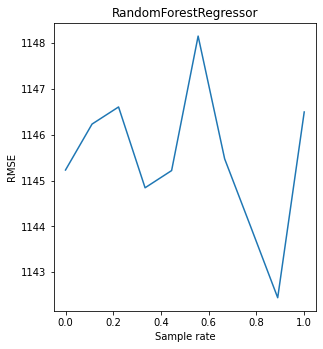

<AxesSubplot:>

Text(0.5, 1.0, 'XGBRegressor')

Text(0.5, 0, 'Sample rate')

Text(0, 0.5, 'RMSE')

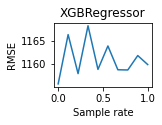

In [25]:
# plot the ideal sampling rate
plt.figure(figsize = (16, 18))

i = 1
for model_name, performance in results.items():
    plt.subplot(3, 3, 1)
    i += 1
    
    plt.plot(sample_rates, performance)
    plt.title(model_name)
    plt.xlabel('Sample rate')
    plt.ylabel('RMSE')
    plt.show()


## Conclusion
As can be seen, different `sample_rate` can give different RMSE, where for Random Forest, i